In [8]:
import warnings
import itertools
import pandas as pd
import numpy as np

import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
%matplotlib inline


### Visualize tractor Sales Data as Time Series

In [9]:
from io import StringIO
import requests

url = 'http://www.ucanalytics.com/blogs/wp-content/uploads/2015/06/Tractor-Sales.csv'
s = requests.get(url).text

sales_data = pd.read_csv(StringIO(s))
sales_data.head(10)

,Month-Year,Number of Tractor Sold
0,Jan-03,141
1,Feb-03,157
2,Mar-03,185
3,Apr-03,199
4,May-03,203
5,Jun-03,189
6,Jul-03,207
7,Aug-03,207
8,Sep-03,171
9,Oct-03,150


In [10]:
#we will take first date of every month as date is not given
dates = pd.date_range(start='2003-01-01',freq='MS',periods=len(sales_data))

In [11]:
import calendar
sales_data['Month'] = dates.month
sales_data['Month'] = sales_data["Month"].apply(lambda x:calendar.month_abbr[x])
sales_data["Year"] = dates.year

In [12]:
sales_data.drop(['Month-Year'], axis=1, inplace=True)
sales_data.rename(columns={'Number of Tractor Sold':'Tractor-Sales'}, inplace=True)
sales_data = sales_data[['Month', 'Year', 'Tractor-Sales']]

In [13]:
sales_data.set_index(dates,inplace=True)
sales_data.head(5)

,Month,Year,Tractor-Sales
2003-01-01,Jan,2003,141
2003-02-01,Feb,2003,157
2003-03-01,Mar,2003,185
2003-04-01,Apr,2003,199
2003-05-01,May,2003,203


Text(0, 0.5, 'Tractor-Sales')

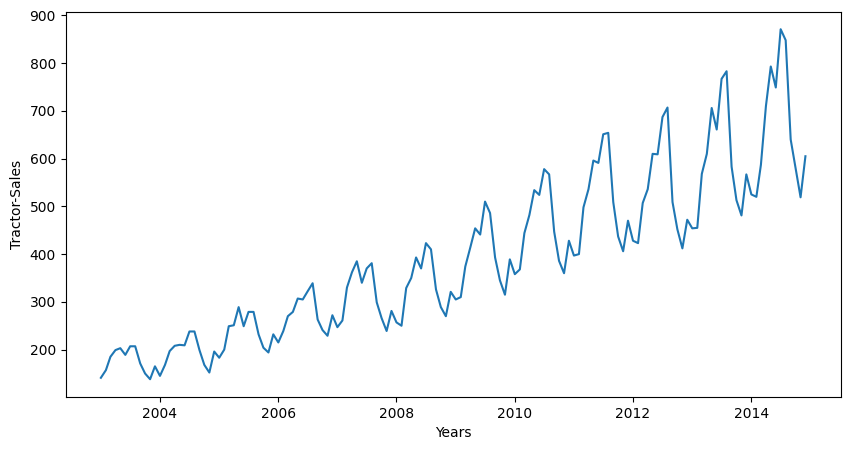

In [14]:
sales_time_series = sales_data['Tractor-Sales']
plt.figure(figsize=(10,5))
plt.plot(sales_time_series)
plt.xlabel('Years')
plt.ylabel('Tractor-Sales')

Business Time Series are divided into four components:
1. Trend
2. seasonality
3. Cycle
4. irregular remainder

Now we will decompose this data to understand underlying patterns such as trend, seasonality, cycle and irregular remainder for tractor sales. As the data span is not 7 years or more, we will exclude cycle. So we will build our model using the following function:
$Y_t = f(Trend_t,Seasonality_t,Remainder_t)$

Step 1: Trend: Time Series decomposition

It is clearly evident from the plot that there is an overall increasing trend in the data along with some seasonal variations. However, it might not always be possible to make such visual inferences. So, more formally, we can check stationarity(if something does not change over time, it is called stationary) using the following:
1. Plotting rolling statistics: We can plot the moving average or moving variance and see if it varies with time. By moving average/variance we mean that at any instant 't', we'll take the average/variance of the last year, i.e. last 12 months.
2. Dickey-Fuller Test: This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the TS is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary.

Moving Average - A good analogy for moving average is ironing clothes to remove wrinkles. The idea with moving average is to remove all the zigzag motion (wrinkles) from the time series to produce a steady trend through averaging adjacent values of a time period. Hence, the formula for moving average is:
$$
\text { MovingAverage }=\frac{\sum_{i=-m}^m Y_{t+i}}{2 m}
$$

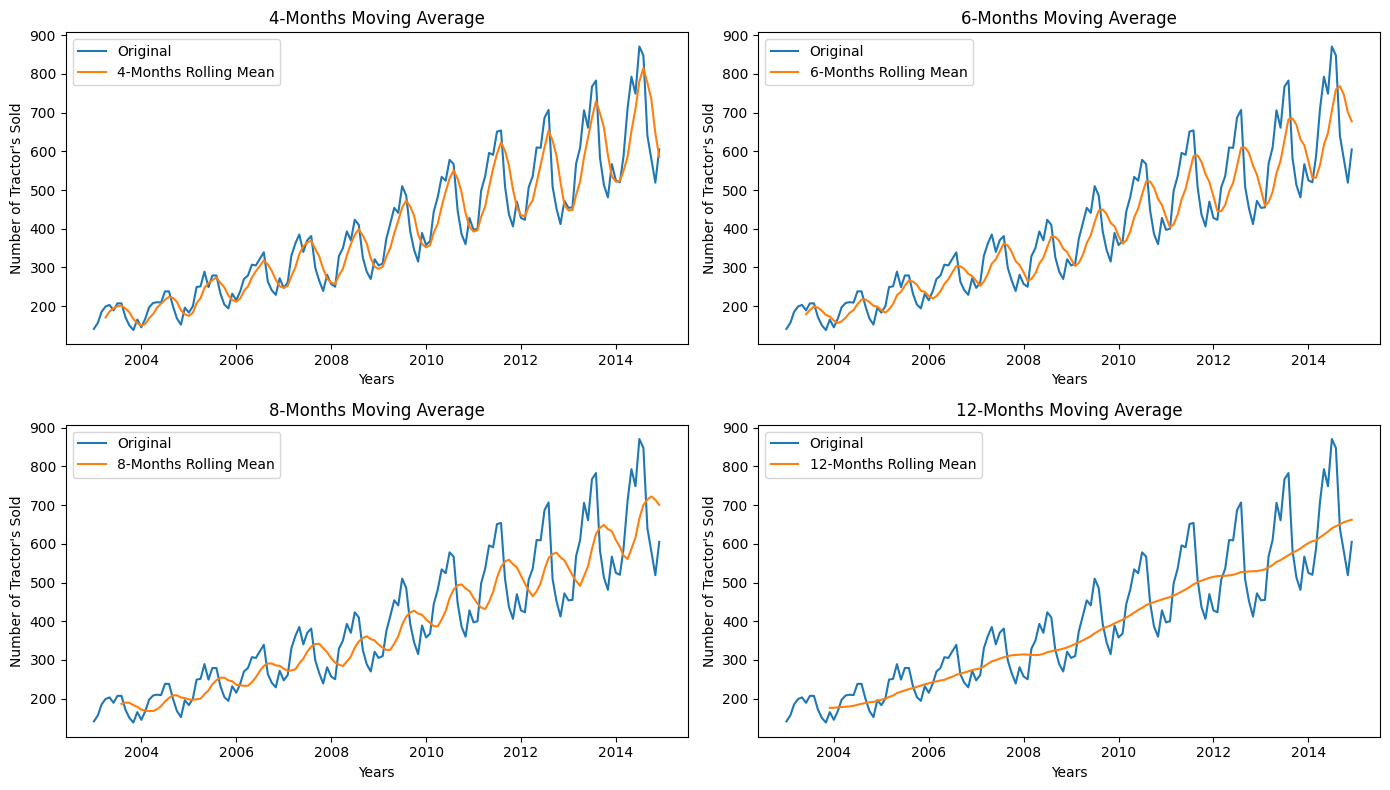

In [15]:
fig,axes = plt.subplots(2,2,sharey=False,sharex=False)
fig.set_figwidth(14)
fig.set_figheight(8)
axes[0][0].plot(sales_time_series.index, sales_time_series, label='Original')
axes[0][0].plot(sales_time_series.index, sales_time_series.rolling(window=4).mean(), label='4-Months Rolling Mean')
axes[0][0].set_xlabel("Years")
axes[0][0].set_ylabel("Number of Tractor's Sold")
axes[0][0].set_title("4-Months Moving Average")
axes[0][0].legend(loc='best')
axes[0][1].plot(sales_time_series.index, sales_time_series, label='Original')
axes[0][1].plot(sales_time_series.index, sales_time_series.rolling(window=6).mean(), label='6-Months Rolling Mean')
axes[0][1].set_xlabel("Years")
axes[0][1].set_ylabel("Number of Tractor's Sold")
axes[0][1].set_title("6-Months Moving Average")
axes[0][1].legend(loc='best')
axes[1][0].plot(sales_time_series.index, sales_time_series, label='Original')
axes[1][0].plot(sales_time_series.index, sales_time_series.rolling(window=8).mean(), label='8-Months Rolling Mean')
axes[1][0].set_xlabel("Years")
axes[1][0].set_ylabel("Number of Tractor's Sold")
axes[1][0].set_title("8-Months Moving Average")
axes[1][0].legend(loc='best')
axes[1][1].plot(sales_time_series.index, sales_time_series, label='Original')
axes[1][1].plot(sales_time_series.index, sales_time_series.rolling(window=12).mean(), label='12-Months Rolling Mean')
axes[1][1].set_xlabel("Years")
axes[1][1].set_ylabel("Number of Tractor's Sold")
axes[1][1].set_title("12-Months Moving Average")
axes[1][1].legend(loc='best')
plt.tight_layout()
plt.show()

As we could see in the above plots, 12-month moving average could produce a wrinkle free curve as desired. This on some level is expected since we are using month-wise data for our analysis and there is expected monthly-seasonal effect in our data.

Let's plot the rolling mean and standard deviation on window of 12 months.

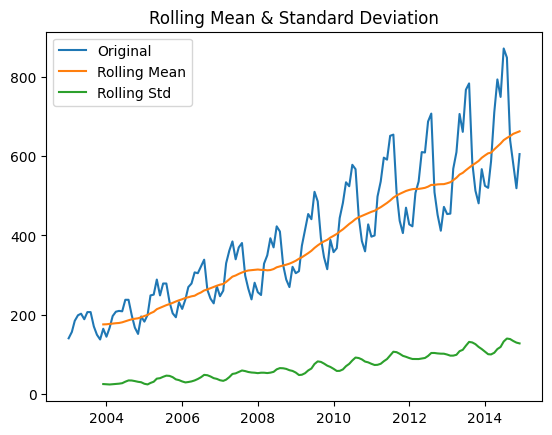

In [16]:
#Determing rolling statistics
rolmean = sales_time_series.rolling(window=12).mean()
rolstd = sales_time_series.rolling(window=12).std()

#Plot rolling statistics:
orig = plt.plot(sales_time_series, label='Original')
mean = plt.plot(rolmean, label='Rolling Mean')
std = plt.plot(rolstd, label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

1. Original (Blue Line): This represents the original data set, which seems to be a time series data, possibly related to economic, financial, or some other measure that fluctuates over time. The data shows significant variability and periodic spikes, suggesting seasonal effects or cyclic patterns.

2. Rolling Mean (Orange Line): This is the moving average, which appears to smooth out the fluctuations of the original data to reveal a clearer upward trend. The rolling mean line shows that overall, whatever is being measured has been increasing over this period. The moving average helps in identifying this trend by averaging out the short-term fluctuations and highlighting longer-term trends or cycles.

3. Rolling Standard Deviation (Green Line): This measures the variability or volatility of the original data over time. In this graph, the rolling standard deviation is relatively stable, suggesting that the level of variability in the data doesn’t change drastically over time, even though the data itself has peaks and troughs.

Dickey-Fuller Test - Let's run the Dicky Fuller Test on the timeseries and verify the null hypothesis that the TS is non-stationary.

In [17]:
from statsmodels.tsa.stattools import adfuller
print("Results of Dickey-Fuller Test:")
dftest = adfuller(sales_time_series,autolag='AIC')
dfoutput = pd.Series(dftest[0:4],index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])
for key, val in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = val
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                   1.108825
p-value                          0.995291
#lags Used                      14.000000
Number of Observations Used    129.000000
Critical Value (1%)             -3.482088
Critical Value (5%)             -2.884219
Critical Value (10%)            -2.578864
dtype: float64


1. Test Statistic: It tests the null hypothesis that a unit root is present in the time series sample. If the time series has a unit root, it means it is non-stationary. Test Statistic = 1.108825: This is higher than any of the critical values.
2. p-value: A lower p-value (typically less than 0.05) indicates strong evidence against the null hypothesis, so we reject the null hypothesis and conclude the series is stationary. p-value = 0.995291: This is very high, which means there is strong evidence that the series is non-stationary.
3. #Lags Used: This indicates the number of lag observations that were used in the test. Lags in this context refer to how many past data points were included when calculating the test statistic. The choice of lags can influence the test's results, and it's usually determined based on some criterion like the Akaike Information Criterion (AIC), which attempts to balance the complexity of the model against how well it fits the data.
4. Number of Observations Used: This is the number of data points used in the test after accounting for the lags. It is the total number of observations minus the number of lags used.
5. Critical Values: These values are used to determine whether the test statistic is indeed statistically significant. They represent the threshold values that the test statistic must cross to reject the null hypothesis of non-stationarity at different confidence levels (1%, 5%, and 10%). If the test statistic is smaller than the critical value at a certain confidence level, we can reject the null hypothesis of non-stationarity with corresponding confidence.


Step 1.2: Seasonality – Time Series Decomposition: The first thing to do is to see how number of tractors sold vary on a month on month basis. We will plot a stacked annual plot to observe seasonality in our data.

In [18]:
monthly_sales_data = pd.pivot_table(sales_data,values="Tractor-Sales",columns="Year",index="Month")
monthly_sales_data = monthly_sales_data.reindex(index = ['Jan','Feb','Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
monthly_sales_data

Year,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
Month,,,,,,,,,,,,
Jan,141.0,145.0,183.0,215.0,247.0,257.0,305.0,358.0,397.0,428.0,454.0,525.0
Feb,157.0,168.0,200.0,239.0,261.0,250.0,310.0,368.0,400.0,423.0,455.0,520.0
Mar,185.0,197.0,249.0,270.0,330.0,329.0,374.0,444.0,498.0,507.0,568.0,587.0
Apr,199.0,208.0,251.0,279.0,362.0,350.0,414.0,482.0,536.0,536.0,610.0,710.0
May,203.0,210.0,289.0,307.0,385.0,393.0,454.0,534.0,596.0,610.0,706.0,793.0
Jun,189.0,209.0,249.0,305.0,340.0,370.0,441.0,524.0,591.0,609.0,661.0,749.0
Jul,207.0,238.0,279.0,322.0,370.0,423.0,510.0,578.0,651.0,687.0,767.0,871.0
Aug,207.0,238.0,279.0,339.0,381.0,410.0,486.0,567.0,654.0,707.0,783.0,848.0
Sep,171.0,199.0,232.0,263.0,299.0,326.0,393.0,447.0,509.0,509.0,583.0,640.0


<Axes: xlabel='Month'>

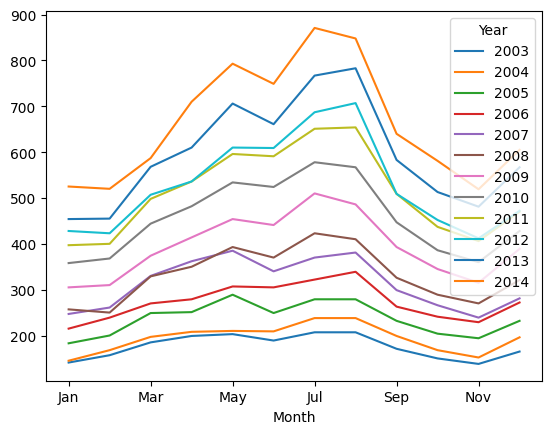

In [19]:
monthly_sales_data.plot()

In [20]:
yearly_sales_data = pd.pivot_table(sales_data, values = "Tractor-Sales", columns = "Month", index = "Year")
yearly_sales_data = yearly_sales_data[['Jan','Feb','Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']]
yearly_sales_data

Month,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
2003,141.0,157.0,185.0,199.0,203.0,189.0,207.0,207.0,171.0,150.0,138.0,165.0
2004,145.0,168.0,197.0,208.0,210.0,209.0,238.0,238.0,199.0,168.0,152.0,196.0
2005,183.0,200.0,249.0,251.0,289.0,249.0,279.0,279.0,232.0,204.0,194.0,232.0
2006,215.0,239.0,270.0,279.0,307.0,305.0,322.0,339.0,263.0,241.0,229.0,272.0
2007,247.0,261.0,330.0,362.0,385.0,340.0,370.0,381.0,299.0,266.0,239.0,281.0
2008,257.0,250.0,329.0,350.0,393.0,370.0,423.0,410.0,326.0,289.0,270.0,321.0
2009,305.0,310.0,374.0,414.0,454.0,441.0,510.0,486.0,393.0,345.0,315.0,389.0
2010,358.0,368.0,444.0,482.0,534.0,524.0,578.0,567.0,447.0,386.0,360.0,428.0
2011,397.0,400.0,498.0,536.0,596.0,591.0,651.0,654.0,509.0,437.0,406.0,470.0


<Axes: >

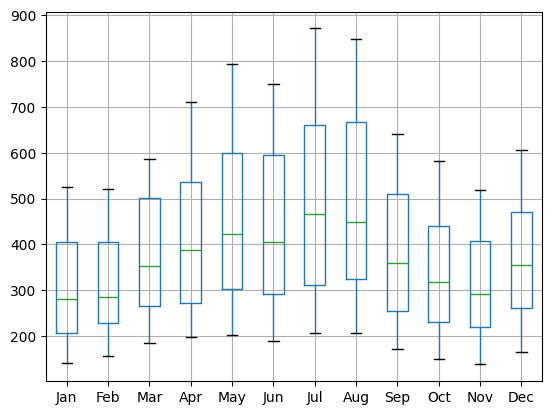

In [21]:
yearly_sales_data.boxplot()

Important Inferences

1. The tractor sales have been increasing without fail every year.
2. July and August are the peak months for tractor sales and the variance and the mean value in July and August are also much higher than any of the other months.
3. We can see a seasonal cycle of 12 months where the mean value of each month starts with a increasing trend in the beginning of the year and drops down towards the end of the year. We can see a seasonal effect with a cycle of 12 months.

Step 1.3: Irregular Remainder – Time Series Decomposition: To decipher underlying patterns in tractor sales, we build a multiplicative time series decomposition model with the following equation:
$Y_t = Trend_t * Seasonality_t * Remainder_t$

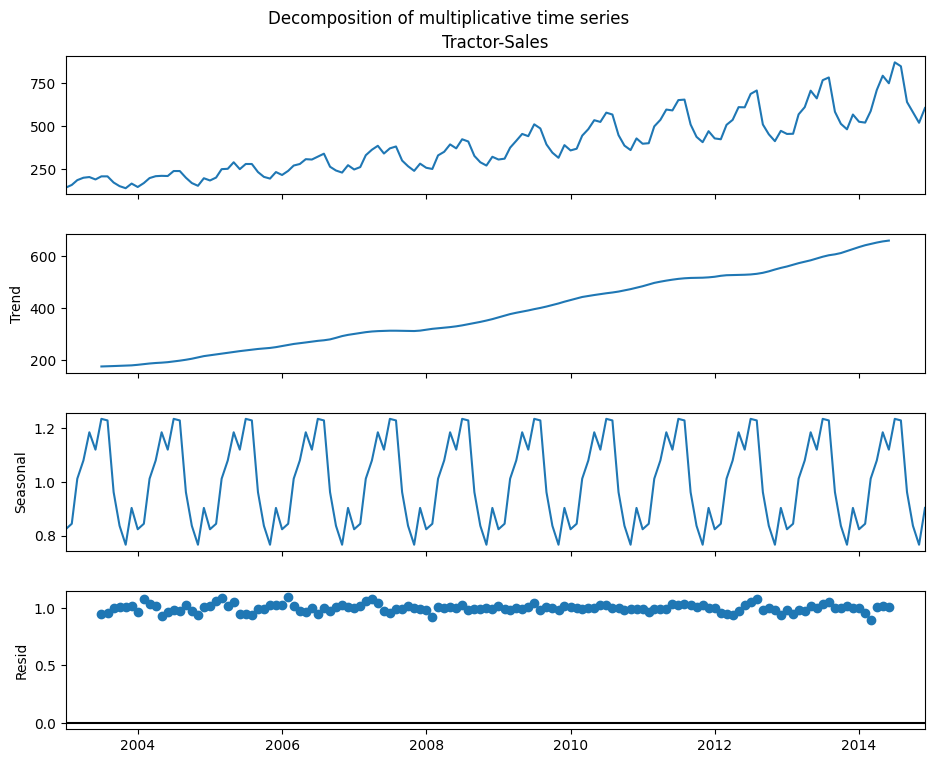

In [22]:
decomposition = sm.tsa.seasonal_decompose(sales_time_series,model='multiplicative')
fig = decomposition.plot()
fig.set_figheight(8)
fig.set_figwidth(10)
fig.suptitle('Decomposition of multiplicative time series')
plt.show()

The following are some of our key observations from this analysis:
1. Trend: 12-months moving average looks quite similar to a straight line hence we could have easily used linear regression to estimate the trend in this data.
2. Seasonality: As discussed, seasonal plot displays a fairly consistent month-on-month pattern. The monthly seasonal components are average values for a month after removal of trend. Trend is removed from the time series using the following formula:
$$
\text { Seasonality }_t \times \text { Remainder }_t=\frac{Y_t}{\text { Trend }_t}
$$
3. Irregular Remainder (random): is the residual left in the series after removal of trend and seasonal components. Remainder is calculated using the following formula:
$$
\text { Remainder }_t=\frac{Y_t}{\text { Trend }_t \times \text { Seasonality }_t}
$$
The expectations from remainder component is that it should look like a white noise i.e. displays no pattern at all. However, for our series residual display some pattern with high variation on the edges of data i.e. near the beginning (2004-07) and the end (2013-14) of the series.